In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from scipy import stats
import os

from tqdm import tqdm

from src.models import RecurrentSpaceNet
from src.data_generation import *

In [2]:
# Generate random env
env = generate_random_polygon_env(add_walls=True, add_holes=True)

# Generate random trajectory
r, v = generate_random_trajectories(env, n_traj=10, timesteps=600, dt=0.1, speed_mean=0.2)

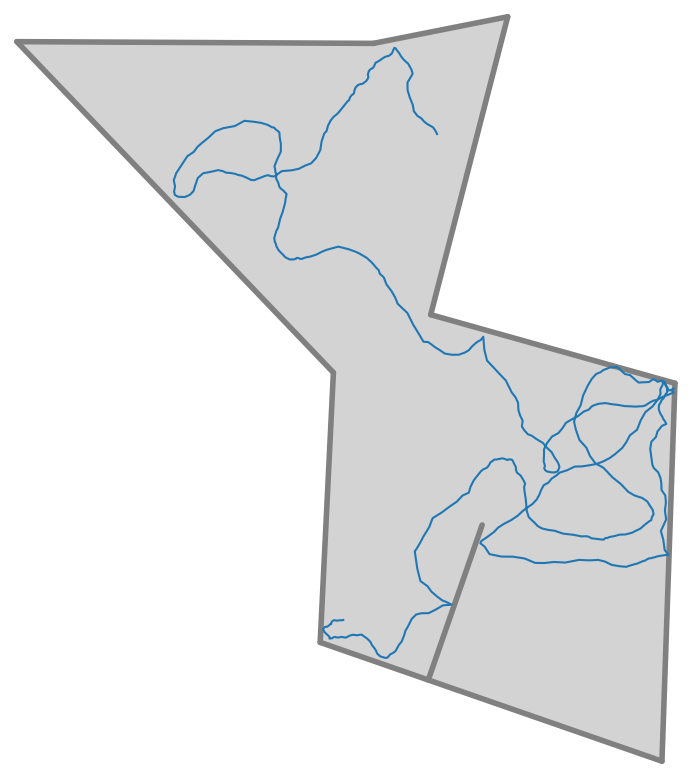

In [3]:
traj_id = 4
fig, ax = env.plot_environment()
ax.plot(r[traj_id, :, 0], r[traj_id, :, 1])
plt.show()

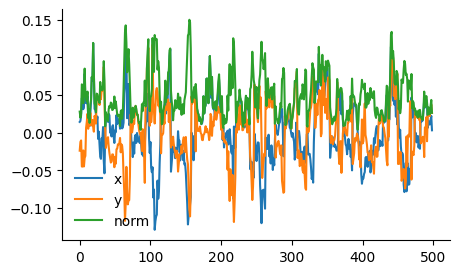

In [27]:
fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(v[0, :, 0], label='x')
ax.plot(v[0, :, 1], label='y')
ax.plot(np.linalg.norm(v[0, :, :], axis=1), label='norm')
ax.legend(frameon=False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

In [117]:
n_traj = 2000       # no. of trajectories per env
n_in = 2            # Cartesian coordinates, no context
n_out = 100         # no. of spatial representations
timesteps = 500     # no. of timesteps
bs = 32             # batch size
epochs = 15         # no. of epochs
dt = 0.1            # timestep
speed_mean = 0.5    # mean speed
lr = 1e-4           # learning rate

### Generate environments

In [31]:
envs = []

We'll add them manually because we want to check them first

(<Figure size 677.61x980.7 with 1 Axes>, <AxesSubplot:>)

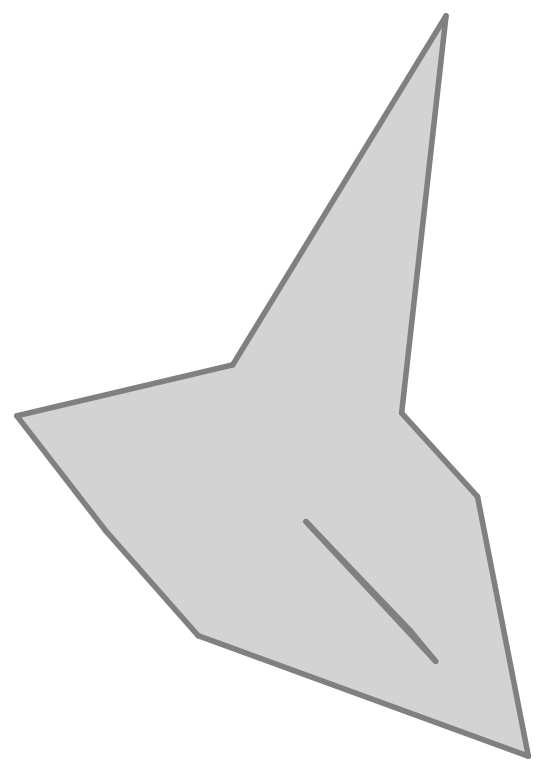

In [63]:
env = generate_random_polygon_env(n_env=1, add_walls=True, add_holes=True)
env.plot_environment()

In [64]:
envs.append(env)

In [65]:
len(envs)

10

Save environments

In [67]:
for i, env in enumerate(envs):
    torch.save(env, os.path.join('/Users/frederikrogge/Data/bsr/datasets', f'env_{i}.pt'))

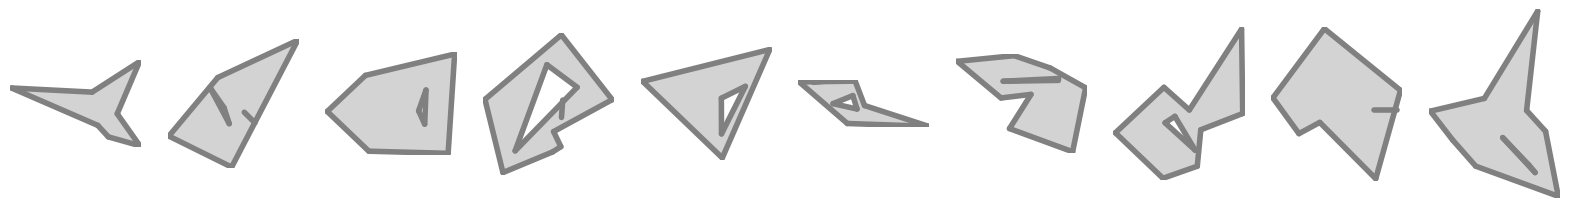

In [132]:
fig, ax = plt.subplots(ncols=10, figsize=(20, 5))
for i in range(10):
    envs[i].plot_environment(fig, ax[i])
plt.show()

### Generate datasets

In [71]:
pb = tqdm(envs)
for i, env in enumerate(pb):

    pb.set_description(f'Generating dataset {i+1}')

    # Generate random trajectories
    r, v = generate_random_trajectories(env, n_traj=n_traj, timesteps=timesteps, dt=dt, speed_mean=speed_mean)

    # Create dataset
    dataset = TensorDataset(r, v)

    # Save dataset
    torch.save(dataset, os.path.join('/Users/frederikrogge/Data/bsr/datasets', f'dataset_{i}.pt'))


Time to generate 2000 trajectories: 76.09 s
Time to generate 2000 trajectories: 84.31 s
Time to generate 2000 trajectories: 86.43 s
Time to generate 2000 trajectories: 90.37 s
Time to generate 2000 trajectories: 94.29 s
Time to generate 2000 trajectories: 95.73 s
Time to generate 2000 trajectories: 101.66 s
Time to generate 2000 trajectories: 120.54 s
Time to generate 2000 trajectories: 115.65 s
Time to generate 2000 trajectories: 119.02 s


### Train model

In [118]:
# Choose env
idx = 4

# Load dataset
dataset = torch.load(os.path.join('/Users/frederikrogge/Data/bsr/datasets', f'dataset_{idx}.pt'))

# Load environment
env = torch.load(os.path.join('/Users/frederikrogge/Data/bsr/datasets', f'env_{idx}.pt'))

In [119]:
# Init model and optimizer
model = RecurrentSpaceNet(n_in, n_out)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Create dataloader
data = DataLoader(dataset, batch_size=bs, shuffle=True)

loss_history = []
for e in range(epochs):

    progress = tqdm(data)
    for i, (r_batch, v_batch) in enumerate(progress): # train loop

        loss = model.train_step(x = v_batch, y = r_batch[:, 1:], optimizer = optimizer)

        if i % 10 == 0:
            loss_history.append(loss)
            progress.set_description(f"loss: {loss:>7f}")

loss: 0.218905: 100%|██████████| 63/63 [00:05<00:00, 11.13it/s]


Text(0, 0.5, 'Train Loss')

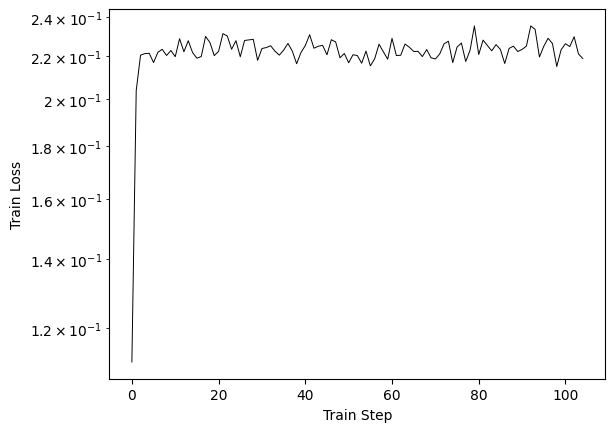

In [120]:
plt.semilogy(loss_history, "-k", linewidth = 0.7)
plt.xlabel("Train Step")
plt.ylabel("Train Loss")

In [121]:
r_test, v_test = generate_random_trajectories(env, n_traj=10, timesteps=timesteps, dt=dt, speed_mean=speed_mean)
p, _ = model.spatial_representation(v_test)
p = p.detach().numpy()
p.shape

(10, 499, 100)

Plot environment and some trajectories

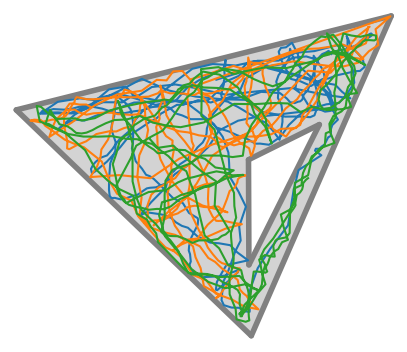

In [122]:
fig, ax = plt.subplots(figsize=(5, 5))
fig, ax = env.plot_environment(fig, ax)
for traj_id in range(3):
    ax.plot(r_test[traj_id, :, 0], r_test[traj_id, :,1])
plt.show()

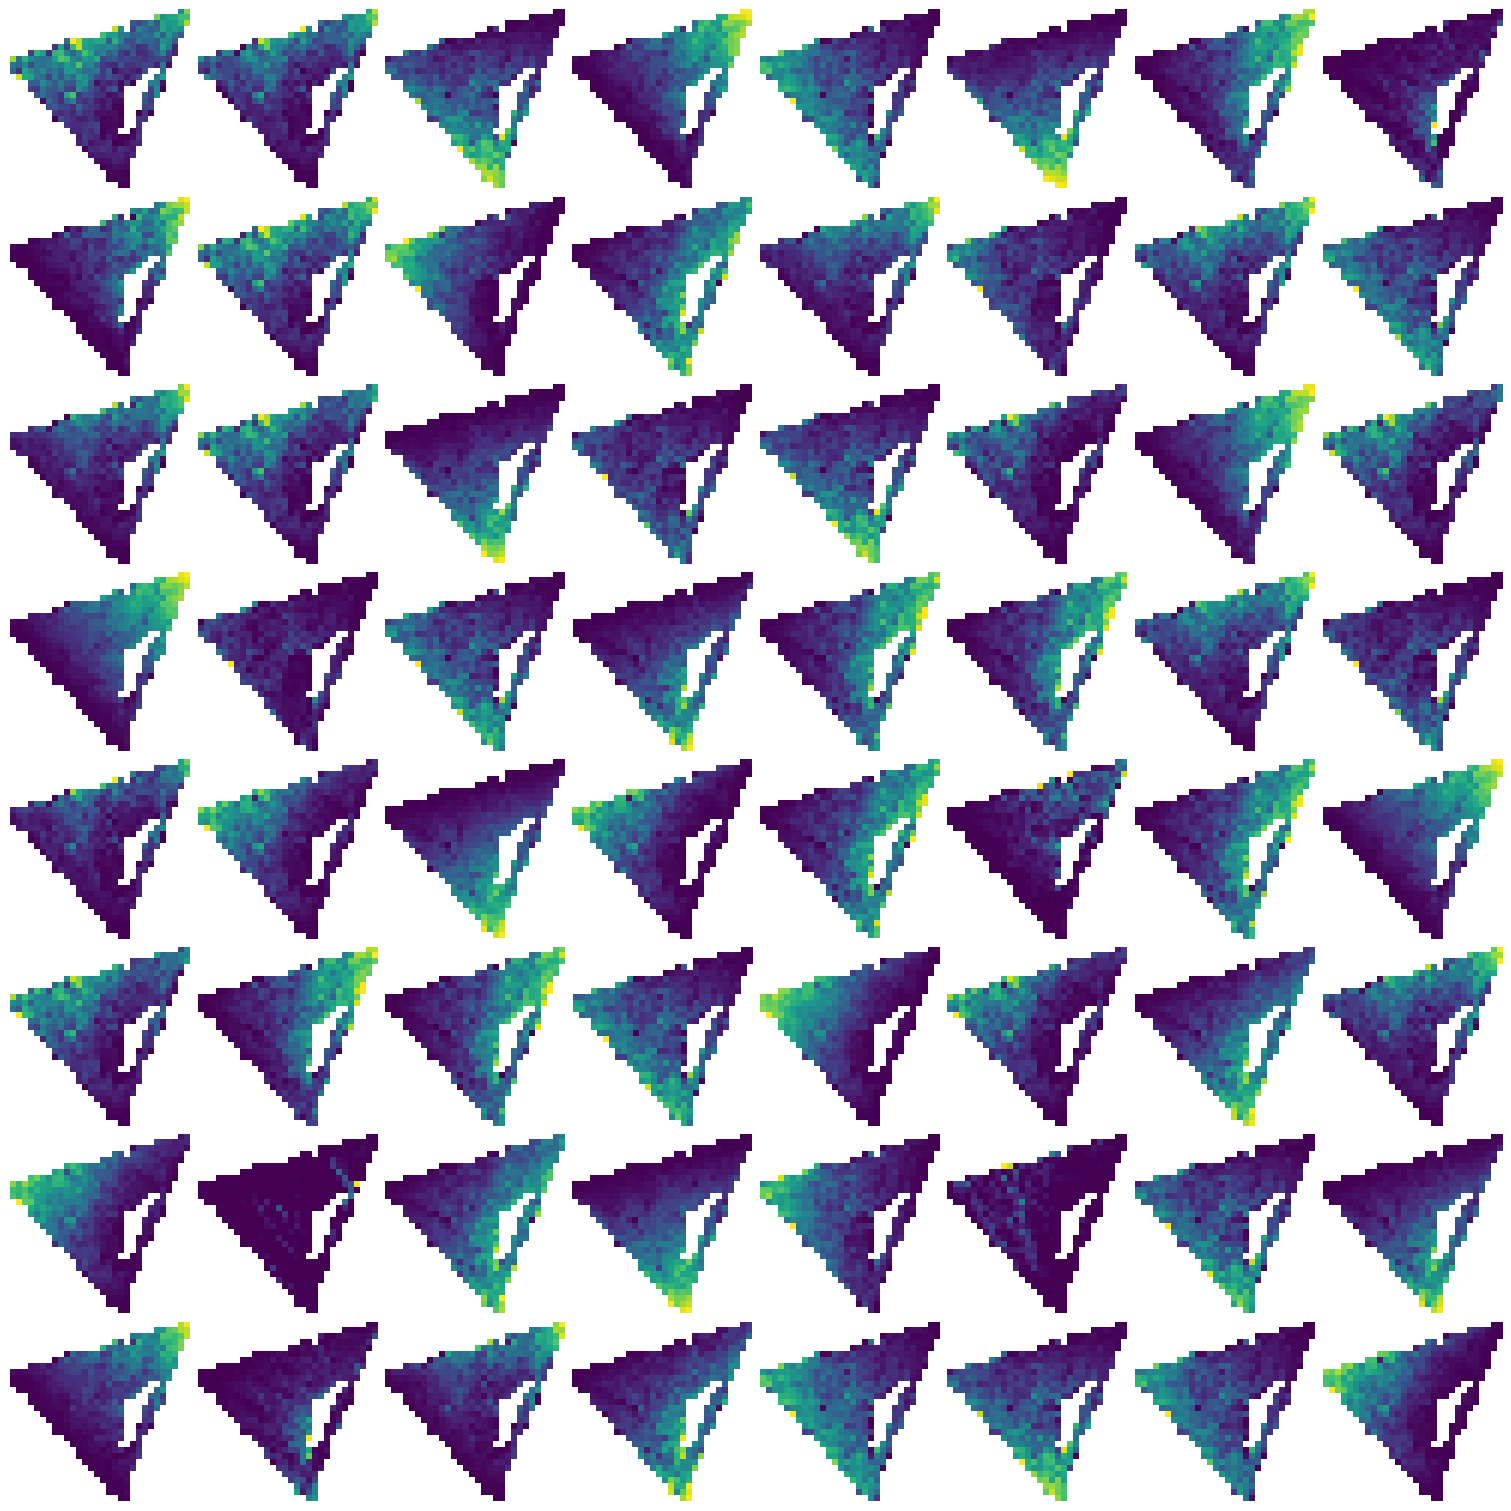

In [123]:
n_show = 8

fig, ax = plt.subplots(n_show, n_show, figsize=(15, 15), constrained_layout=True)
r0 = r_test[:,1:].detach().numpy()

ps = p.reshape(-1, n_out)
rs = r0.reshape(-1, 2)

for i in range(n_show**2):
    hist, _, _, _ = stats.binned_statistic_2d(values=ps[:, i], x=rs[:,0], y=rs[:,1], bins=30)
    ax[i//n_show, i%n_show].imshow(hist.T, origin="lower")
    ax[i//n_show, i%n_show].axis("off")

### Train on multiple environments

In [124]:
dataset, envs = [], []

for i in range(10):

    # Load dataset
    dataset.append(torch.load(os.path.join('/Users/frederikrogge/Data/bsr/datasets', f'dataset_{i}.pt')))

    # Load environment
    envs.append(torch.load(os.path.join('/Users/frederikrogge/Data/bsr/datasets', f'env_{i}.pt')))

dataset = torch.utils.data.ConcatDataset(dataset)

In [126]:
epochs = 5

# Init model and optimizer
model = RecurrentSpaceNet(n_in, n_out)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Create dataloader
data = DataLoader(dataset, batch_size=bs, shuffle=True)

loss_history = []
for e in range(epochs):

    progress = tqdm(data)
    for i, (r_batch, v_batch) in enumerate(progress): # train loop

        loss = model.train_step(x = v_batch, y = r_batch[:, 1:], optimizer = optimizer)

        if i % 10 == 0:
            loss_history.append(loss)
            progress.set_description(f"loss: {loss:>7f}")

loss: 0.112814: 100%|██████████| 625/625 [00:59<00:00, 10.47it/s]


Text(0, 0.5, 'Train Loss')

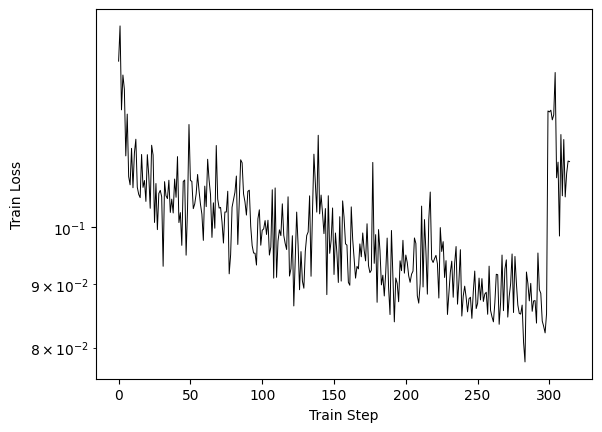

In [127]:
plt.semilogy(loss_history, "-k", linewidth = 0.7)
plt.xlabel("Train Step")
plt.ylabel("Train Loss")

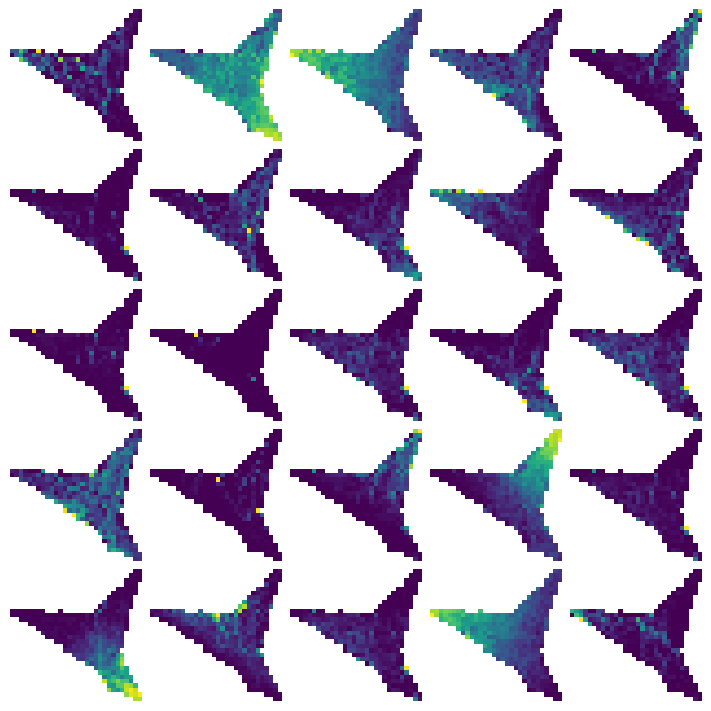

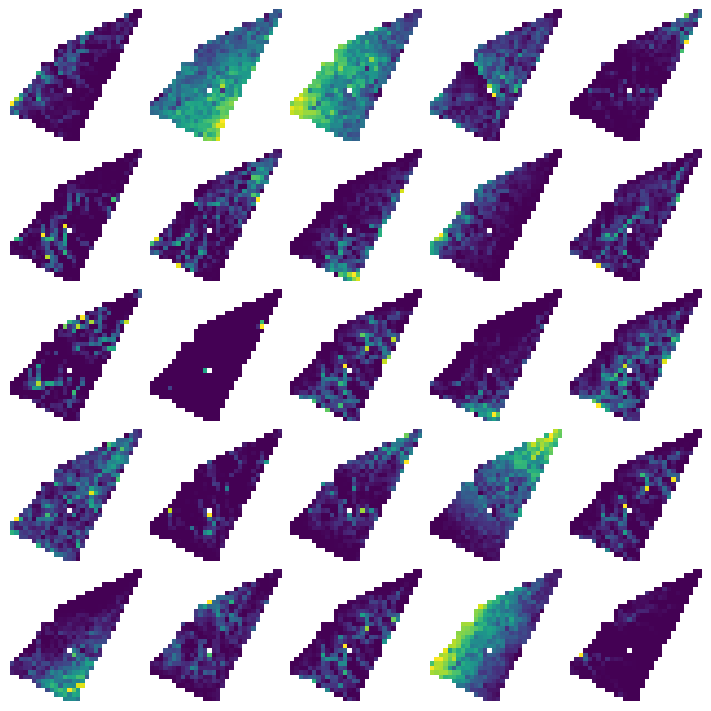

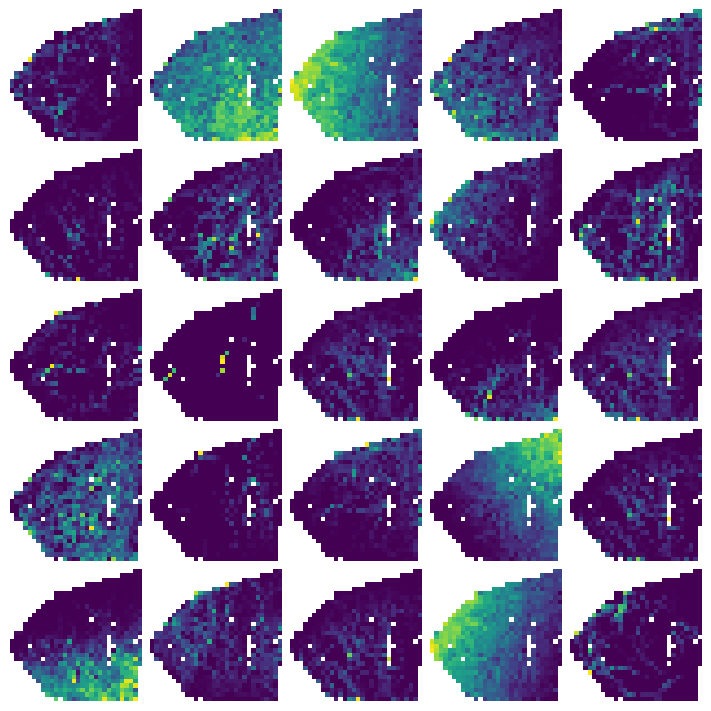

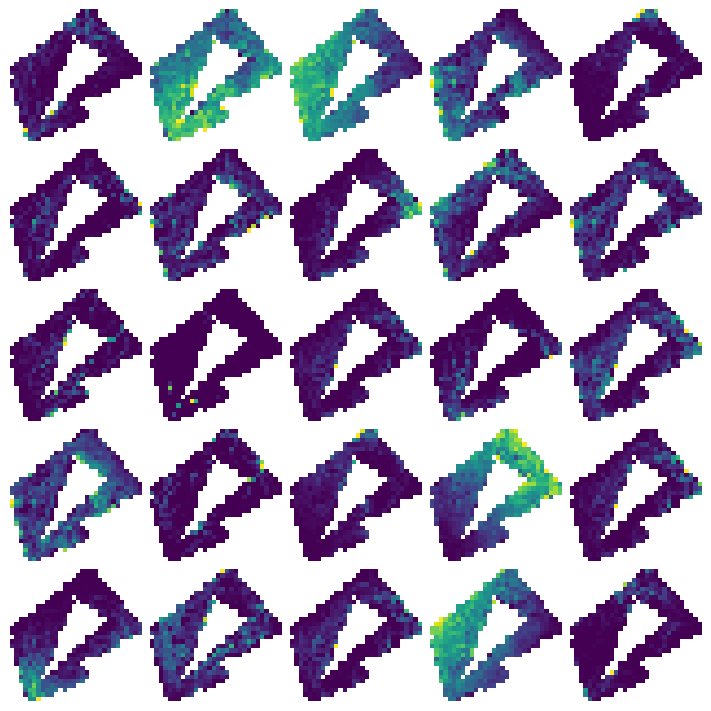

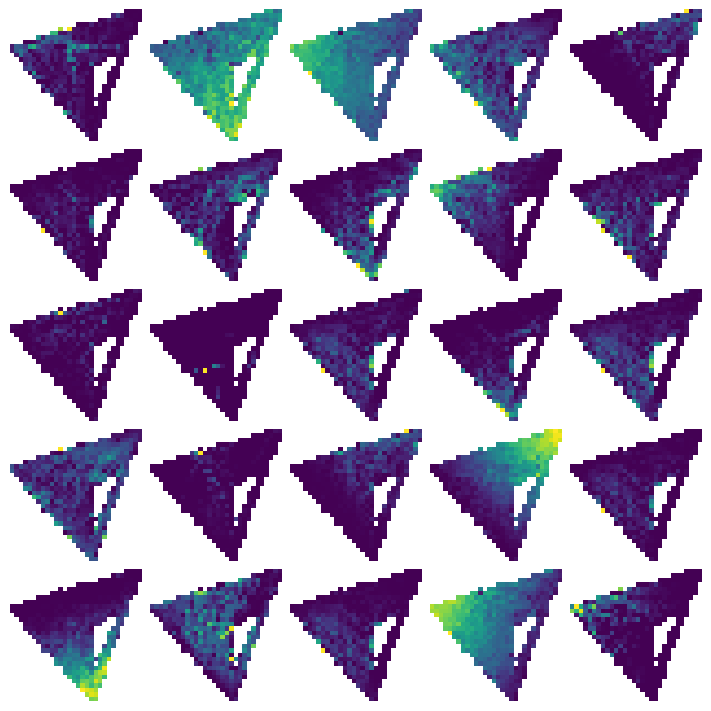

In [129]:
n_show = 5

for k in range(5):

    r_test, v_test = generate_random_trajectories(envs[k], n_traj=10, timesteps=timesteps, dt=dt, speed_mean=speed_mean)
    p, _ = model.spatial_representation(v_test)
    p = p.detach().numpy()

    fig, ax = plt.subplots(n_show, n_show, figsize=(7, 7), constrained_layout=True)
    r0 = r_test[:,1:].detach().numpy()

    ps = p.reshape(-1, n_out)
    rs = r0.reshape(-1, 2)

    for i in range(n_show**2):
        hist, _, _, _ = stats.binned_statistic_2d(values=ps[:, i], x=rs[:,0], y=rs[:,1], bins=30)
        ax[i//n_show, i%n_show].imshow(hist.T, origin="lower")
        ax[i//n_show, i%n_show].axis("off")

    plt.show()